### Initial package imports

In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Initial files being read in and dataset creation

In [2]:
pd.set_option('display.float_format', '{:.6f}'.format)
# Read the data
main_df = pd.read_csv('Data/Cleaned_Indices_Assignment1.csv', sep=';')

# Read the interest rate data
#interest_rate_df = pd.read_csv('Data/ECB_Rates_2012_to_2022.csv', sep=';')
interest_rate_bond_df = pd.read_csv('Data/ECB_Data_10yr_Treasury_bond.csv', sep=',')

# Convert date columns to datetime format for proper merging
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%d-%m-%Y')
#interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['Date'], format='%d-%m-%Y')
#gov_bond_investment_df['Date'] = pd.to_datetime(gov_bond_investment_df['Date'], format='%Y-%m-%d')
interest_rate_bond_df['Date'] = pd.to_datetime(interest_rate_bond_df['Date'], format='%Y-%m-%d')

# Merge the dataframes on the Date column
main_df = pd.merge(main_df, interest_rate_bond_df, on='Date', how='left')
#main_df = pd.merge(main_df, gov_bond_investment_df, on='Date', how='left')

# Remove rows where the bond does not have a yield curve spot rate (Market closed?)
main_df = main_df.dropna(axis=0, subset=['Yield curve spot rate, 10-year maturity - Government bond'])

# Filter the dataframe to start from 2012-01-04
main_df = main_df[main_df['Date'] >= '2012-01-04']
main_df = main_df.reset_index(drop=True)

### government bond column

In [3]:
	
# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000

# Initialize the arrays with appropriate lengths matching the DataFrame
interest_bond_vector = np.zeros(len(main_df))
interest_bond_profit_vector = np.zeros(len(main_df))
interest_bond_loss_vector = np.zeros(len(main_df))
daily_rates = np.zeros(len(main_df))

# Set initial value
interest_bond_vector[0] = interest_bond


# Calculate bond values day by day based on the daily yield rate
for i in range(len(main_df)):
    # Adding 1.5% to account for the credit risk spread
    daily_rate = (((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[i] + 1.5) / (days_per_annum)) * (7/5)) / 100
    daily_rates[i] = daily_rate
    
    if i > 0:
        previous_value = interest_bond_vector[i-1]
        current_value = previous_value * (1 + daily_rate)
        interest_bond_vector[i] = current_value
        
        # Calculate change, profit/loss and return
        change = current_value - previous_value
        interest_bond_profit_vector[i] = change
        interest_bond_loss_vector[i] = -change

# Add vectors to the dataframe
main_df['Interest_Bond'] = interest_bond_vector
main_df['Interest_Bond_Profit'] = interest_bond_profit_vector
main_df['Interest_Bond_Loss'] = interest_bond_loss_vector
main_df['Interest_Bond_daily_rate'] = daily_rates




## Portfolio details

### details

#### Instruments:
- **S&P500**
- **DAX40**
- **NIKKEI**
- **EU Government Bond (10-year maturity, AAA-rated)**

#### Invested amount:
- **10,000,000 EURO**

#### Period:
- **01/01/2012 - 31/12/2022**

#### Weights:
- **S&P500**: 0.4  
- **DAX40**: 0.3  
- **NIKKEI**: 0.15  
- **EU Government Bond**: 0.15  

#### Measures:
- **Value at Risk (VaR)**: 1, 5, 10 days  
- **Expected Shortfall (ES)**  



### weights and currency correction


In [4]:
# initial investment 
weights = {
    'S&P500': 0.4,
    'DAX40': 0.3,
    'NIKKEI': 0.15,
    'EU-BOND': 0.15,
}

starting_investment = 10000000  # 10 million euros
starting_date = '2012-01-04'

# Filter the main_df for the starting date
starting_row = main_df[main_df['Date'] == starting_date]

# Extract the exchange rates for the starting date
usd_to_eur = float(starting_row['USD/EUR'].iloc[0])
jpy_to_eur = float(starting_row['JPY/EUR'].iloc[0])

# Calculate the invested amounts
invested_amount_SP500 = starting_investment * weights['S&P500'] / usd_to_eur
invested_amount_DAX40 = starting_investment * weights['DAX40']
invested_amount_NIKKEI = starting_investment * weights['NIKKEI'] / jpy_to_eur
invested_amount_EU_BOND = starting_investment * weights['EU-BOND']

invested_amounts = [
    invested_amount_SP500, #in USD
    invested_amount_DAX40, #in EUR
    invested_amount_NIKKEI, #in JPY
    invested_amount_EU_BOND #in EUR
]

print(invested_amounts)

[5177993.527508091, 3000000.0, 148957298.90764648, 1500000.0]


### Returns Portfolio 

In [5]:
# Create columns to track investments for each asset
# Initialize the first day with the initial invested amounts
main_df.loc[0, 'SP500_Investment'] = invested_amount_SP500
main_df.loc[0, 'DAX40_Investment'] = invested_amount_DAX40
main_df.loc[0, 'NIKKEI_Investment'] = invested_amount_NIKKEI
main_df.loc[0, 'EU_BOND_Investment'] = invested_amount_EU_BOND

# Calculate daily investment values for subsequent days
# This uses cumulative returns to track the value growth
for i in range(1, len(main_df)):
    # S&P 500 in USD
    main_df.loc[i, 'SP500_Investment'] = main_df.loc[i-1, 'SP500_Investment'] * (1 + main_df.loc[i, 'C_S&P500_Returns'])
    
    # DAX 40 in EUR
    main_df.loc[i, 'DAX40_Investment'] = main_df.loc[i-1, 'DAX40_Investment'] * (1 + main_df.loc[i, 'C_Dax40_Returns'])
    
    # NIKKEI in JPY
    main_df.loc[i, 'NIKKEI_Investment'] = main_df.loc[i-1, 'NIKKEI_Investment'] * (1 + main_df.loc[i, 'C_Nikkei_Returns'])
    
# EU Government Bond value is already calculated in the Interest_Bond column
main_df['EU_BOND_Investment'] = main_df['Interest_Bond']

# Methods input values 

### Portfolio change Daily

In [6]:
# Calculate total portfolio value in EUR for each day
main_df['Portfolio_Value_EUR'] = (
    main_df['SP500_Investment'].fillna(0) * main_df['USD/EUR'] +
    main_df['DAX40_Investment'].fillna(0) +
    main_df['NIKKEI_Investment'].fillna(0) * main_df['JPY/EUR'] +
    main_df['EU_BOND_Investment'].fillna(0)
)

# First day should be the initial investment amount
main_df.loc[0, 'Portfolio_Value_EUR'] = starting_investment

# Calculate the daily change in portfolio value (profit/loss)
main_df['Portfolio_Change_EUR'] = main_df['Portfolio_Value_EUR'].diff()
main_df.loc[0, 'Portfolio_Change_EUR'] = 0.0  # Set the first day's change to 0

# Portfolio loss is the negative of the daily change
main_df['Portfolio_loss'] = -main_df['Portfolio_Change_EUR']

# Set the first day's loss to 0 (there's no previous day to compare with)
main_df.loc[0, 'Portfolio_loss'] = 0.0

# Display the relevant columns to verify
display(main_df[['Date', 'SP500_Investment', 'DAX40_Investment', 'NIKKEI_Investment', 
                'EU_BOND_Investment', 'USD/EUR', 'JPY/EUR', 'Portfolio_Value_EUR', 
                'Portfolio_Change_EUR', 'Portfolio_loss']].head(20))

,Date,SP500_Investment,DAX40_Investment,NIKKEI_Investment,EU_BOND_Investment,USD/EUR,JPY/EUR,Portfolio_Value_EUR,Portfolio_Change_EUR,Portfolio_loss
0,2012-01-04,5177993.527508,3000000.000000,148957298.907646,1500000.000000,0.772500,0.010070,10000000.000000,0.000000,0.000000
1,2012-01-05,5189897.180583,2992352.262000,148944667.328699,1500246.523142,0.782100,0.010120,10058937.403442,58937.403442,-58937.403442
2,2012-01-06,5179533.786296,2973606.159562,148926943.509066,1500493.291886,0.786100,0.010210,10066275.054084,7337.650642,-7337.650642
3,2012-01-09,5188699.359796,2953565.582481,148926943.509066,1500738.323863,0.783300,0.010190,10036177.669230,-30097.384854,30097.384854
4,2012-01-10,5224622.209432,3024254.466714,148932706.981779,1500982.736072,0.782600,0.010190,10131650.828032,95473.158802,-95473.158802
5,2012-01-11,5225894.770664,3019028.766693,148937338.788967,1501223.999292,0.786900,0.010230,10156138.336831,24487.508799,-24487.508799
6,2012-01-12,5235403.197359,3032185.494802,148926138.701090,1501460.534432,0.779600,0.010160,10128255.931098,-27882.405733,27882.405733
7,2012-01-13,5214914.028114,3014404.192042,148946848.667790,1501695.498805,0.789000,0.010260,10158861.526361,30605.595263,-30605.595263
8,2012-01-16,5214914.028114,3051919.263087,148924774.744817,1501930.470054,0.789500,0.010280,10201971.042714,43109.516353,-43109.516353
9,2012-01-17,5229430.909452,3106827.837990,148940684.676353,1502166.395712,0.784900,0.010220,10235748.351923,33777.309209,-33777.309209


In [7]:
loss_values = main_df['Portfolio_loss'].values

# Calculate and print the minimum, maximum, and mean of portfolio loss values
min_loss = np.nanmin(loss_values)
max_loss = np.nanmax(loss_values)
mean_loss = np.nanmean(loss_values)

print(f"Portfolio Loss Statistics:")
print(f"Minimum Loss: {min_loss:.4f}")
print(f"Maximum Loss: {max_loss:.4f}")
print(f"Mean Loss: {mean_loss:.4f}")

# Also print the number of valid loss values (non-NaN)
valid_count = np.sum(~np.isnan(loss_values))
print(f"Number of valid loss values: {valid_count} out of {len(loss_values)}")

Portfolio Loss Statistics:
Minimum Loss: -850226.1277
Maximum Loss: 1342732.3566
Mean Loss: -3159.9667
Number of valid loss values: 2803 out of 2805


In [8]:
def calculate_daily_loss_variables(time_window, current_date):
    # Calculate the mean and standard deviation of portfolio loss from the time windows
    loss_dict = {
        "Date": current_date,
        "Portfolio_mean_loss": np.nanmean(time_window['Portfolio_loss']),
        "Portfolio_std_loss": np.nanstd(time_window['Portfolio_loss'])
    }
    return loss_dict

### Portfolio variance

## Value at Risk (VaR)

In [9]:
def VaR(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the VaR of the normal model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional) double, degrees of freedom for student-t

    Return value:
        dVaR    double, VaR
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dVaR = r + s*dVaR0
    else:
        dVaR0= st.t.ppf(alpha, df= df)

        dS2t= df/(df-2)

        c = s / np.sqrt(dS2t)
        dVaR= r + c*dVaR0
    return dVaR

## Expected Shortfall (ES) 

In [10]:
def ES(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the ES of the normal/student model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional, default= 0/normal) double, df

    Return value:
        dES     double, ES
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dES0= st.norm.pdf(dVaR0) / (1-alpha)
        dES= r + s*dES0
    else:
        dVaR0= st.t.ppf(alpha, df= df)
        dES0= st.t.pdf(dVaR0, df= df)*((df + dVaR0**2)/(df-1)) / (1-alpha)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dES= r + c*dES0
    return dES

# performing different methods

write method for variance covariance where the sample period is an input parameter alongside other parameters that are needed for the calculation

## 1. var/cov multivar normal dist & T-distribution & Historical

4 code blocks with functions to calculate components of Var/cov method, 1 code block with for loop to iterate through set window for daily VaR and ES

### Main method

In [11]:
def calculate_var_cov(window, current_date, vAlpha, mean_loss, portfolio_std_loss, df=0):
    """
    Calculate Value at Risk using variance-covariance method.
    
    Parameters:
    - window: DataFrame containing the time window
    - current_date: Current date for reporting
    - vAlpha: Confidence levels (array)
    - mean_loss: Mean loss for the portfolio
    - portfolio_std_loss: Standard deviation of losses
    - df: Degrees of freedom for t-distribution (0 for normal distribution)
    
    Returns:
    - Dictionary with date, VaR and ES values
    """
    # Calculate VaR and ES
    var_result = VaR(vAlpha, mean_loss, portfolio_std_loss, df=df)
    es_result = ES(vAlpha, mean_loss, portfolio_std_loss, df=df)
    
    # Set label for distribution type
    if df == 0:
        dist_label = "Normal"
    else:
        dist_label = f"T{df}"
        
    return {
        'Date': current_date,
        f'VaR {dist_label}': var_result,
        f'ES {dist_label}': es_result
    }

def calculate_historical_var_es(window, current_date, vAlpha):
    """
    Calculate VaR and ES using historical simulation method.
    """
    # Extract portfolio loss values from the window
    historical_losses = window['Portfolio_loss'].dropna()
    
    # Sort losses in ascending order
    sorted_losses = np.sort(historical_losses)
    
    # Calculate VaR for alpha levels
    var_hist = np.percentile(sorted_losses, 100*vAlpha)
    
    # Calculate ES for each alpha level
    es_hist = []
    for i, alpha in enumerate(vAlpha):
        es_hist.append(sorted_losses[sorted_losses >= var_hist[i]].mean())
    
    return {
        'Date': current_date,
        'VaR Historical': var_hist,
        'ES Historical': es_hist
    }

def calculate_multiday_var(vAlpha, interval, sample_size):
    """
    Calculate multi-day VaR using the historical simulation method.
    
    Parameters:
    - vAlpha: Confidence levels (array)
    - interval: Number of days for the multi-day calculation (e.g., 5 or 10)
    
    Returns:
    - var_multi: VaR values at specified confidence levels
    """
    # Filter data for the period we want to analyze
    time_window_multi = main_df[(main_df['Date'] >= '2012-01-05') & (main_df['Date'] <= '2021-12-31')]
    # Create a new DataFrame for storing multi-day losses
    multi_day_losses = []
    
    # Calculate rolling sum of losses over the interval
    for i in range(sample_size, len(time_window_multi) - interval + 1, interval):
        window = time_window_multi.iloc[i:i+interval]
        if len(window) == interval:  # Ensure we have a complete window
            total_loss = window['Portfolio_loss'].sum()
            date = window['Date'].iloc[-1]
            daily_loss = window['Portfolio_loss'].iloc[-1]
            multi_day_losses.append({'Date': date, 'Portfolio_loss': total_loss, 'Daily_loss': daily_loss})

    # Convert to DataFrame
    multi_day_losses_df = pd.DataFrame(multi_day_losses)

    # Calculate VaR as percentiles of the multi-day losses for each row
    var_list = []
    for idx, row in multi_day_losses_df.iterrows():
        var_95 = np.percentile(multi_day_losses_df['Portfolio_loss'][:idx+1], vAlpha[0]*100)
        var_99 = np.percentile(multi_day_losses_df['Portfolio_loss'][:idx+1], vAlpha[1]*100)
        var_list.append([var_95, var_99])
    multi_day_losses_df[f'VaR_{interval}d_reg'] = var_list

    # calculate VaR per row using the square root of time rule for each alpha level
    sqrt_var_list = []
    for idx, row in multi_day_losses_df.iterrows():
        var_95 = np.percentile(multi_day_losses_df['Daily_loss'][:idx+1], vAlpha[0]*100) * np.sqrt(interval)
        var_99 = np.percentile(multi_day_losses_df['Daily_loss'][:idx+1], vAlpha[1]*100) * np.sqrt(interval)
        sqrt_var_list.append([var_95, var_99])
    multi_day_losses_df[f'VaR_{interval}d_sqrt'] = sqrt_var_list

    return multi_day_losses_df[['Date', 'Portfolio_loss', f'VaR_{interval}d_reg','Daily_loss', f'VaR_{interval}d_sqrt']]


In [12]:
def main():
    # Initialize lists to store results
    VaR_results = []
    ES_results = []
    # Define time window
    time_window = main_df[(main_df['Date'] >= '2012-01-05') & (main_df['Date'] <= '2021-12-31')]

    # Define confidence levels
    vAlpha = np.array([0.95, 0.99])
    
    # Define sample size and t-distribution degrees of freedom
    sample_size = 500
    degrees_of_freedom = [0, 3, 4, 5, 6]  # 0 represents normal distribution
    
    for i in range(sample_size, len(time_window)):
        # Extract the rolling window
        window = time_window.iloc[i - sample_size:i]
        current_date = time_window.iloc[i]['Date']
        
        # Calculate loss statistics
        loss_stats = calculate_daily_loss_variables(window, current_date)
        mean_loss = loss_stats["Portfolio_mean_loss"]
        portfolio_std_loss = loss_stats["Portfolio_std_loss"]
        
        # Initialize result dictionaries for this date
        var_row = {'Date': current_date}
        es_row = {'Date': current_date}

        
        # Calculate VaR and ES using various distributions
        for df in degrees_of_freedom:
            results = calculate_var_cov(window, current_date, vAlpha, mean_loss, portfolio_std_loss, df)
            
            # Get the distribution label
            if df == 0:
                dist_label = "Normal"
            else:
                dist_label = f"T{df}"
                
            # Add results to the dictionaries
            var_row[f'VaR {dist_label}'] = results[f'VaR {dist_label}']
            es_row[f'ES {dist_label}'] = results[f'ES {dist_label}']
        
        # Calculate VaR and ES using historical simulation
        hist_results = calculate_historical_var_es(window, current_date, vAlpha)
        var_row['VaR Historical'] = hist_results['VaR Historical']
        es_row['ES Historical'] = hist_results['ES Historical']
        
        # Add results for this date
        VaR_results.append(var_row)
        ES_results.append(es_row)

    # Convert results to DataFrame
    var_results_df = pd.DataFrame(VaR_results)
    es_results_df = pd.DataFrame(ES_results)

    var_5d = calculate_multiday_var(vAlpha, 5, sample_size)
    var_10d = calculate_multiday_var(vAlpha, 10, sample_size)

    return var_results_df, es_results_df, var_5d, var_10d

In [13]:
var_results_df, es_results_df, var_5d, var_10d = main()
print("VaR results")
display(var_results_df.head())
print("ES results")
display(es_results_df.head())
print("5-day VaR results")
display(var_5d.head())
print("10-day VaR results")
display(var_10d.head())

VaR results


,Date,VaR Normal,VaR T3,VaR T4,VaR T5,VaR T6,VaR Historical
0,2013-12-18,"[81302.63724237992, 116557.82173332498]","[66500.06233789833, 131830.61781966424]","[74194.10217215758, 133274.76768026515]","[76956.93381443433, 131048.8178940729]","[78289.05285881073, 128954.41137094288]","[76635.87745611469, 124145.5344469194]"
1,2013-12-19,"[81540.3660070524, 116948.8599203884]","[66673.4211597873, 132288.0707363653]","[74400.91901787695, 133738.50057490906]","[77175.76501008144, 131502.87110384434]","[78513.67685923811, 129399.35692012627]","[76635.87745611469, 124145.5344469194]"
2,2013-12-20,"[81583.82165663296, 117072.39289918296]","[66683.25478523278, 132446.29378239065]","[74428.22860238179, 133900.0038098057]","[77209.34998874959, 131659.3183982767]","[78550.28756410255, 129551.04705662336]","[76635.87745611469, 124145.5344469194]"
3,2013-12-23,"[81449.94297045414, 116946.14401575756]","[66546.17257797203, 132323.3501836578]","[74292.81151210057, 133777.37274889508]","[77074.53082075343, 131536.20560515978]","[78415.75668861427, 129427.48099942949]","[76635.87745611469, 124145.5344469194]"
4,2013-12-24,"[81344.2515656486, 116759.42526174705]","[66474.5020816722, 132101.5298070153]","[74203.4577257698, 133552.23326793505]","[76978.82719034994, 131316.18204724038]","[78316.99143545798, 129212.27103733084]","[76635.87745611469, 124145.5344469194]"


ES results


,Date,ES Normal,ES T3,ES T4,ES T5,ES T6,ES Historical
0,2013-12-18,"[102919.40446331202, 134088.11726814165]","[111925.80079269716, 205375.9477153037]","[113372.33536064536, 187180.662555394]","[112022.79145338114, 174626.62119015018]","[110710.06207567592, 166541.3106481568]","[111708.34702453166, 164482.1976745602]"
1,2013-12-19,"[103251.13512144932, 134555.38706543748]","[112296.696340737, 206153.21719823903]","[113749.52125668032, 187878.80867822265]","[112394.1087715062, 175270.17526196092]","[111075.67090622509, 167149.7052304643]","[111708.34702453166, 164482.1976745602]"
2,2013-12-20,"[103343.69030093697, 134718.73771266945]","[112409.70831755288, 206478.48840127286]","[113865.81883890402, 188162.75177984586]","[112507.341049341, 175525.6035758192]","[111185.92149883926, 167386.76886737032]","[111708.34702453166, 164482.1976745602]"
3,2013-12-23,"[103214.48983932125, 134596.2826740096]","[112282.45698848333, 206371.46122358963]","[113738.88056374664, 188051.78684268647]","[112380.11071064833, 175411.92173728038]","[111058.40706388204, 167271.33723442463]","[111708.34702453166, 164482.1976745602]"
4,2013-12-24,"[103059.11639848091, 134369.27386341666]","[112106.38405532726, 205980.61086699113]","[113559.4830454759, 187702.7548950915]","[112203.81486287006, 175091.7428706811]","[110885.12827538834, 166969.74091930466]","[111708.34702453166, 164482.1976745602]"


5-day VaR results


,Date,Portfolio_loss,VaR_5d_reg,Daily_loss,VaR_5d_sqrt
0,2013-12-24,-317147.190141,"[-317147.19014117867, -317147.19014117867]",-13228.655178,"[-29580.172229564894, -29580.172229564894]"
1,2014-01-03,9600.043583,"[-6737.318103086776, 6332.571245885525]",-51794.217489,"[-33891.93317540233, -30442.524418732384]"
2,2014-01-10,-11515.501879,"[7488.489036888627, 9177.732673880606]",-11031.622743,"[-25158.729742614156, -24765.712632662977]"
3,2014-01-17,-177350.520089,"[6432.711763768635, 8966.577219256604]",-33797.473085,"[-25404.365436333643, -24814.839771406878]"
4,2014-01-24,306362.137941,"[247009.71906936535, 294491.6541666128]",175135.223325,"[308357.9200167155, 374962.9956910937]"


10-day VaR results


,Date,Portfolio_loss,VaR_10d_reg,Daily_loss,VaR_10d_sqrt
0,2014-01-03,-307547.146558,"[-307547.14655805007, -307547.14655805007]",-51794.217489,"[-163787.69689066155, -163787.69689066155]"
1,2014-01-17,-188866.021968,"[-194800.07819735174, -190052.8332137434]",-33797.473085,"[-109722.52924603212, -107446.1011346793]"
2,2014-01-31,275549.909135,"[229108.31602437457, 266261.59051257157]",18115.676528,"[40870.419854296066, 54003.523317508276]"
3,2014-02-14,-191148.540901,"[205887.51946925133, 261617.43120154683]",-47507.700075,"[32662.2301897884, 52361.88538460671]"
4,2014-02-28,-9322.539775,"[218575.4193527415, 264155.01117824495]",-21981.075152,"[31927.38676653227, 52214.91669995551]"


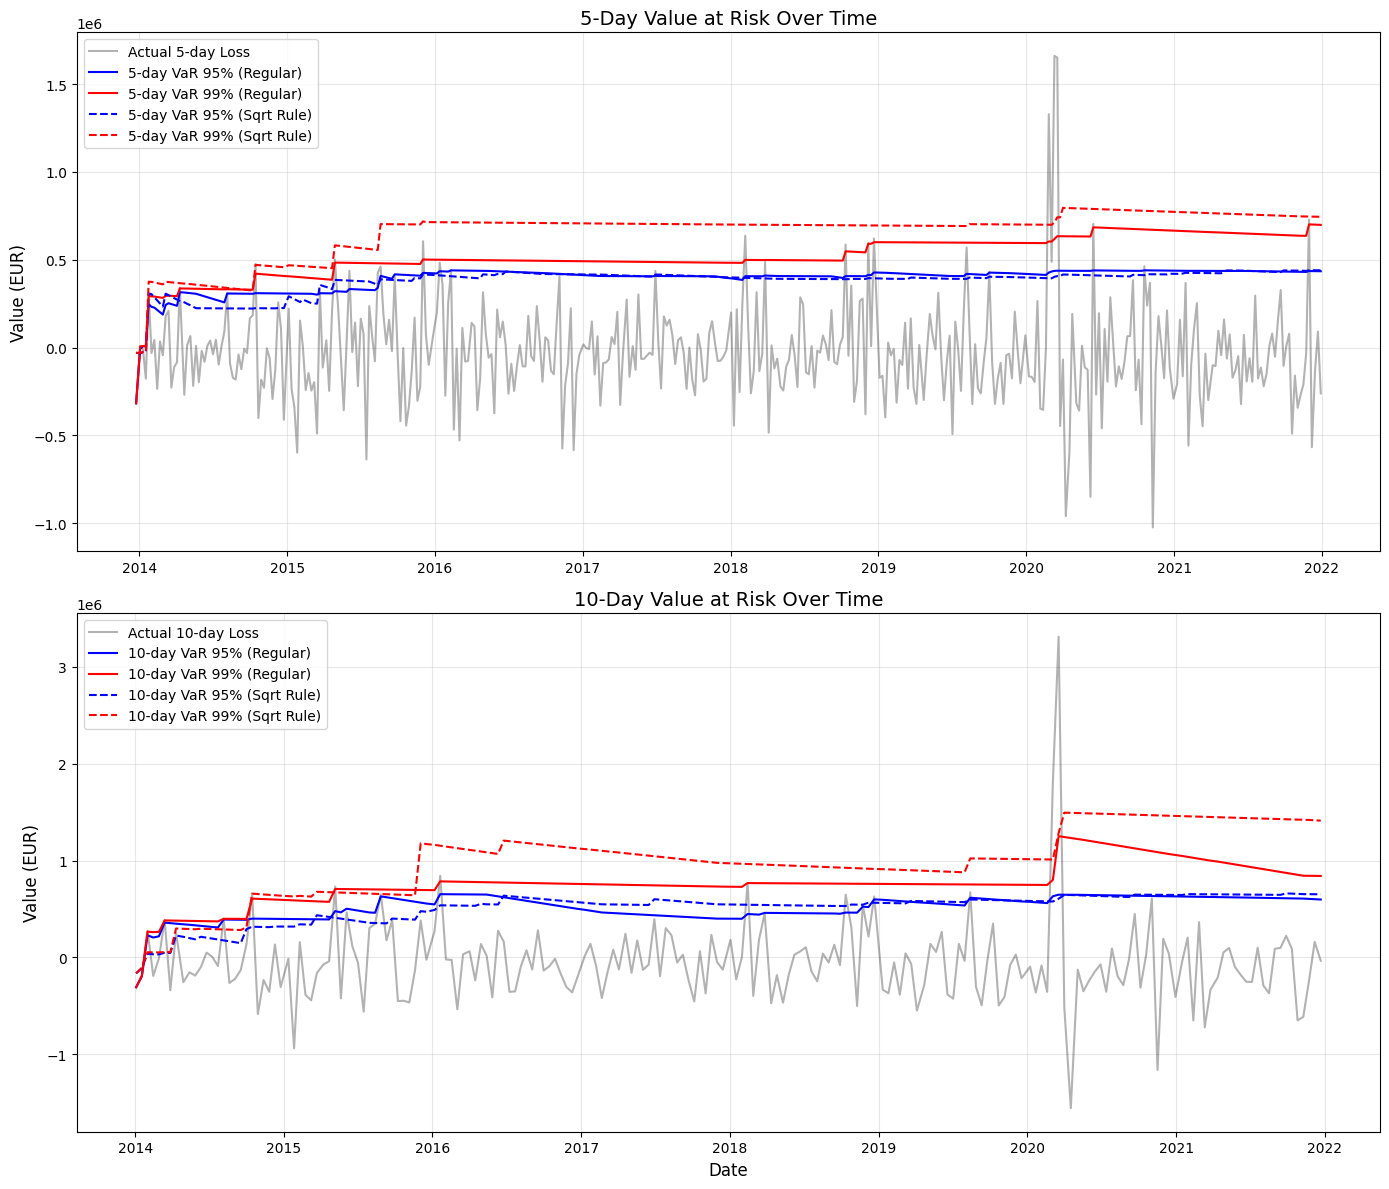

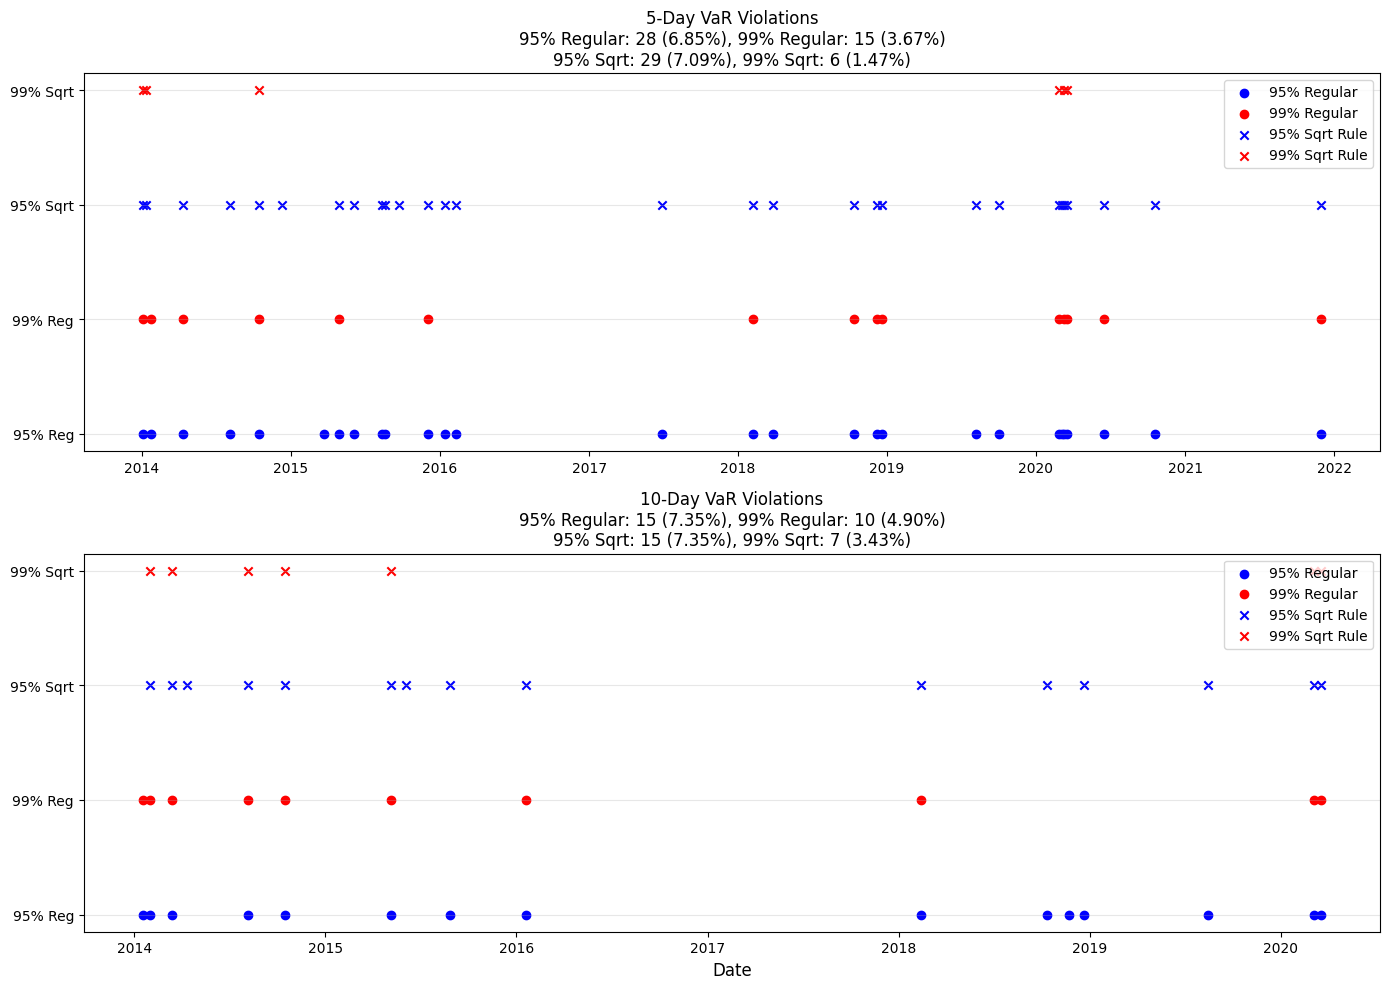

In [14]:
# Create a plot for 5-day and 10-day VaR over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

# ------- 5-day VaR Plot ------- 
# Extract regular and sqrt VaR values for 95% and 99% levels
var5d_reg_95 = [row[0] for row in var_5d['VaR_5d_reg']]
var5d_reg_99 = [row[1] for row in var_5d['VaR_5d_reg']]
var5d_sqrt_95 = [row[0] for row in var_5d['VaR_5d_sqrt']]
var5d_sqrt_99 = [row[1] for row in var_5d['VaR_5d_sqrt']]

# Plot actual portfolio losses
ax1.plot(var_5d['Date'], var_5d['Portfolio_loss'], 'k-', alpha=0.3, label='Actual 5-day Loss')

# Plot regular and sqrt VaR values
ax1.plot(var_5d['Date'], var5d_reg_95, 'b-', label='5-day VaR 95% (Regular)')
ax1.plot(var_5d['Date'], var5d_reg_99, 'r-', label='5-day VaR 99% (Regular)')
ax1.plot(var_5d['Date'], var5d_sqrt_95, 'b--', label='5-day VaR 95% (Sqrt Rule)')
ax1.plot(var_5d['Date'], var5d_sqrt_99, 'r--', label='5-day VaR 99% (Sqrt Rule)')

# Customize 5-day plot
ax1.set_title('5-Day Value at Risk Over Time', fontsize=14)
ax1.set_ylabel('Value (EUR)', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# ------- 10-day VaR Plot ------- 
# Extract regular and sqrt VaR values for 95% and 99% levels
var10d_reg_95 = [row[0] for row in var_10d['VaR_10d_reg']]
var10d_reg_99 = [row[1] for row in var_10d['VaR_10d_reg']]
var10d_sqrt_95 = [row[0] for row in var_10d['VaR_10d_sqrt']]
var10d_sqrt_99 = [row[1] for row in var_10d['VaR_10d_sqrt']]

# Plot actual portfolio losses
ax2.plot(var_10d['Date'], var_10d['Portfolio_loss'], 'k-', alpha=0.3, label='Actual 10-day Loss')

# Plot regular and sqrt VaR values
ax2.plot(var_10d['Date'], var10d_reg_95, 'b-', label='10-day VaR 95% (Regular)')
ax2.plot(var_10d['Date'], var10d_reg_99, 'r-', label='10-day VaR 99% (Regular)')
ax2.plot(var_10d['Date'], var10d_sqrt_95, 'b--', label='10-day VaR 95% (Sqrt Rule)')
ax2.plot(var_10d['Date'], var10d_sqrt_99, 'r--', label='10-day VaR 99% (Sqrt Rule)')

# Customize 10-day plot
ax2.set_title('10-Day Value at Risk Over Time', fontsize=14)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Value (EUR)', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Adjust layout to prevent clipping of labels
plt.tight_layout()
plt.show()

# Create a plot to compare the violations between 5-day and 10-day VaR
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# ----- 5-day VaR Violations -----
# Calculate violations (when actual loss exceeds VaR)
violations_5d_reg_95 = var_5d['Portfolio_loss'] > np.array(var5d_reg_95)
violations_5d_reg_99 = var_5d['Portfolio_loss'] > np.array(var5d_reg_99)
violations_5d_sqrt_95 = var_5d['Portfolio_loss'] > np.array(var5d_sqrt_95)
violations_5d_sqrt_99 = var_5d['Portfolio_loss'] > np.array(var5d_sqrt_99)

# Plot violations
ax1.scatter(var_5d['Date'][violations_5d_reg_95], [1]*sum(violations_5d_reg_95), color='blue', marker='o', label='95% Regular')
ax1.scatter(var_5d['Date'][violations_5d_reg_99], [2]*sum(violations_5d_reg_99), color='red', marker='o', label='99% Regular')
ax1.scatter(var_5d['Date'][violations_5d_sqrt_95], [3]*sum(violations_5d_sqrt_95), color='blue', marker='x', label='95% Sqrt Rule')
ax1.scatter(var_5d['Date'][violations_5d_sqrt_99], [4]*sum(violations_5d_sqrt_99), color='red', marker='x', label='99% Sqrt Rule')

# Add violation counts to the legend
ax1.set_title(f'5-Day VaR Violations\n' + 
             f'95% Regular: {sum(violations_5d_reg_95)} ({sum(violations_5d_reg_95)/len(var_5d)*100:.2f}%), ' + 
             f'99% Regular: {sum(violations_5d_reg_99)} ({sum(violations_5d_reg_99)/len(var_5d)*100:.2f}%)\n' + 
             f'95% Sqrt: {sum(violations_5d_sqrt_95)} ({sum(violations_5d_sqrt_95)/len(var_5d)*100:.2f}%), ' + 
             f'99% Sqrt: {sum(violations_5d_sqrt_99)} ({sum(violations_5d_sqrt_99)/len(var_5d)*100:.2f}%)', 
             fontsize=12)
             
ax1.set_yticks([1, 2, 3, 4])
ax1.set_yticklabels(['95% Reg', '99% Reg', '95% Sqrt', '99% Sqrt'])
ax1.legend(loc='upper right')
ax1.grid(True, axis='y', alpha=0.3)

# ----- 10-day VaR Violations -----
# Calculate violations (when actual loss exceeds VaR)
violations_10d_reg_95 = var_10d['Portfolio_loss'] > np.array(var10d_reg_95)
violations_10d_reg_99 = var_10d['Portfolio_loss'] > np.array(var10d_reg_99)
violations_10d_sqrt_95 = var_10d['Portfolio_loss'] > np.array(var10d_sqrt_95)
violations_10d_sqrt_99 = var_10d['Portfolio_loss'] > np.array(var10d_sqrt_99)

# Plot violations
ax2.scatter(var_10d['Date'][violations_10d_reg_95], [1]*sum(violations_10d_reg_95), color='blue', marker='o', label='95% Regular')
ax2.scatter(var_10d['Date'][violations_10d_reg_99], [2]*sum(violations_10d_reg_99), color='red', marker='o', label='99% Regular')
ax2.scatter(var_10d['Date'][violations_10d_sqrt_95], [3]*sum(violations_10d_sqrt_95), color='blue', marker='x', label='95% Sqrt Rule')
ax2.scatter(var_10d['Date'][violations_10d_sqrt_99], [4]*sum(violations_10d_sqrt_99), color='red', marker='x', label='99% Sqrt Rule')

# Add violation counts to the legend
ax2.set_title(f'10-Day VaR Violations\n' + 
             f'95% Regular: {sum(violations_10d_reg_95)} ({sum(violations_10d_reg_95)/len(var_10d)*100:.2f}%), ' + 
             f'99% Regular: {sum(violations_10d_reg_99)} ({sum(violations_10d_reg_99)/len(var_10d)*100:.2f}%)\n' + 
             f'95% Sqrt: {sum(violations_10d_sqrt_95)} ({sum(violations_10d_sqrt_95)/len(var_10d)*100:.2f}%), ' + 
             f'99% Sqrt: {sum(violations_10d_sqrt_99)} ({sum(violations_10d_sqrt_99)/len(var_10d)*100:.2f}%)', 
             fontsize=12)
             
ax2.set_yticks([1, 2, 3, 4])
ax2.set_yticklabels(['95% Reg', '99% Reg', '95% Sqrt', '99% Sqrt'])
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot Historical VaR and ES over time
plt.figure(figsize=(12, 6))

# Extract the values for different confidence levels from the arrays
var_95 = [row[0] for row in var_results_df['VaR Historical']]
var_99 = [row[1] for row in var_results_df['VaR Historical']]
es_95 = [row[0] for row in es_results_df['ES Historical']]
es_99 = [row[1] for row in es_results_df['ES Historical']]

# Plot VaR Historical 95% and 99%
plt.plot(var_results_df['Date'], var_95, label='VaR Historical 95%', color='blue')
plt.plot(var_results_df['Date'], var_99, label='VaR Historical 99%', color='red')

# Plot ES Historical 95% and 99%
plt.plot(es_results_df['Date'], es_95, label='ES Historical 95%', color='green', linestyle='--')
plt.plot(es_results_df['Date'], es_99, label='ES Historical 99%', color='orange', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Historical VaR and ES Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Create subplots for all indices
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# S&P 500
sp500_returns = main_df['C_S&P500_Returns'].dropna()
mu_sp500 = sp500_returns.mean()
sigma_sp500 = sp500_returns.std()
x_sp500 = np.linspace(mu_sp500 - 4*sigma_sp500, mu_sp500 + 4*sigma_sp500, 100)
ax1.hist(sp500_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax1.plot(x_sp500, st.norm.pdf(x_sp500, mu_sp500, sigma_sp500), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_sp500 / np.sqrt(df/(df-2))
    ax1.plot(x_sp500, st.t.pdf((x_sp500-mu_sp500)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax1.set_title('S&P500 Returns Distribution')
ax1.legend()
ax1.grid(True)

# DAX40
dax_returns = main_df['C_Dax40_Returns'].dropna()
mu_dax = dax_returns.mean()
sigma_dax = dax_returns.std()
x_dax = np.linspace(mu_dax - 4*sigma_dax, mu_dax + 4*sigma_dax, 100)
ax2.hist(dax_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax2.plot(x_dax, st.norm.pdf(x_dax, mu_dax, sigma_dax), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_dax / np.sqrt(df/(df-2))
    ax2.plot(x_dax, st.t.pdf((x_dax-mu_dax)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax2.set_title('DAX40 Returns Distribution')
ax2.legend()
ax2.grid(True)

# NIKKEI
nikkei_returns = main_df['C_Nikkei_Returns'].dropna()
mu_nikkei = nikkei_returns.mean()
sigma_nikkei = nikkei_returns.std()
x_nikkei = np.linspace(mu_nikkei - 4*sigma_nikkei, mu_nikkei + 4*sigma_nikkei, 100)
ax3.hist(nikkei_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax3.plot(x_nikkei, st.norm.pdf(x_nikkei, mu_nikkei, sigma_nikkei), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_nikkei / np.sqrt(df/(df-2))
    ax3.plot(x_nikkei, st.t.pdf((x_nikkei-mu_nikkei)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax3.set_title('NIKKEI Returns Distribution')
ax3.legend()
ax3.grid(True)

# EU Bond
bond_returns = main_df['Interest_Bond_daily_rate'].dropna()
mu_bond = bond_returns.mean()
sigma_bond = bond_returns.std()
x_bond = np.linspace(mu_bond - 4*sigma_bond, mu_bond + 4*sigma_bond, 100)
ax4.hist(bond_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax4.plot(x_bond, st.norm.pdf(x_bond, mu_bond, sigma_bond), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_bond / np.sqrt(df/(df-2))
    ax4.plot(x_bond, st.t.pdf((x_bond-mu_bond)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax4.set_title('EU Bond Returns Distribution')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

## GARCH(1,1) with constant conditional correlation 

## EWMA

In [ ]:
def calculate_ewma_volatility(loss_series, lambda_=0.94):
    weights = (1 - lambda_) * (lambda_ ** np.arange(len(loss_series)-1, -1, -1))
    weighted_squared_losses = weights * (loss_series ** 2)
    ewma_variance = weighted_squared_losses.sum()
    return np.sqrt(ewma_variance)


In [ ]:
def calculate_ewma_vol_series(loss_series, lambda_=0.94):
    ewma_var = [loss_series.iloc[0] ** 2]  # Seed with squared first value
    for t in range(1, len(loss_series)):
        prev_var = ewma_var[-1]
        new_var = lambda_ * prev_var + (1 - lambda_) * (loss_series.iloc[t - 1] ** 2)
        ewma_var.append(new_var)
    return pd.Series(np.sqrt(ewma_var), index=loss_series.index)


In [ ]:
def main_ewma():
    # Initialize lists to store results
    mean_losses = []
    portfolio_std_losses = []
    ewma_vol_94 = []  # For λ = 0.94
    ewma_vol_97 = []  # For λ = 0.97
    VaR_results = []
    ES_results = []

    time_window = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]
    vAlpha = np.array([0.95, 0.99])
    sample_size = 500
    degrees_of_freedom = [0, 3, 4, 5, 6]

    fhs_results = []


    for i in range(sample_size, len(time_window)):
        window = time_window.iloc[i - sample_size:i]
        current_date = time_window.iloc[i]['Date']
        
        loss_stats = calculate_daily_loss_variables(window, current_date)
        mean_loss = loss_stats["Portfolio_mean_loss"]
        std_loss = loss_stats["Portfolio_std_loss"]
        
        # Calculate EWMA volatilities for both lambda values
        ewma_94 = calculate_ewma_volatility(window['Portfolio_loss'], lambda_=0.94)
        ewma_97 = calculate_ewma_volatility(window['Portfolio_loss'], lambda_=0.97)

        # --- Filtered Historical Simulation (FHS) using EWMA filtered losses ---
        factors = ['C_S&P500_Loss', 'C_Dax40_Loss', 'C_Nikkei_Loss', 'Interest_Bond_Loss']
        filtered_losses = []

        for factor in factors:
            series = window[factor]
            vol_series = calculate_ewma_vol_series(series, lambda_=0.94)
            current_vol = vol_series.iloc[-1]

            normalized = series / vol_series
            normalized = normalized.replace([np.inf, -np.inf], 0).fillna(0)

            filtered = normalized * current_vol
            filtered_losses.append(filtered)

        # Combine into filtered portfolio loss
        filtered_portfolio_loss = np.sum(filtered_losses, axis=0)

        # Calculate FHS VaR and ES
        FHS_VaR_95 = np.percentile(filtered_portfolio_loss, 5)
        FHS_VaR_99 = np.percentile(filtered_portfolio_loss, 1)
        FHS_ES_95 = filtered_portfolio_loss[filtered_portfolio_loss <= FHS_VaR_95].mean()
        FHS_ES_99 = filtered_portfolio_loss[filtered_portfolio_loss <= FHS_VaR_99].mean()

        # Store results
        fhs_results.append({
            'Date': current_date,
            'FHS_VaR_95': FHS_VaR_95,
            'FHS_VaR_99': FHS_VaR_99,
            'FHS_ES_95': FHS_ES_95,
            'FHS_ES_99': FHS_ES_99
        })

        
        # Append everything
        mean_losses.append(mean_loss)
        portfolio_std_losses.append(std_loss)
        ewma_vol_94.append(ewma_94)
        ewma_vol_97.append(ewma_97)
        
        var_row = {'Date': current_date}
        es_row = {'Date': current_date}
        
        for df in degrees_of_freedom:
            current_var = VaR(vAlpha, mean_loss, std_loss, df)
            current_es = ES(vAlpha, mean_loss, std_loss, df)
            
            var_key = f"VaR {'Normal' if df == 0 else f'T{df}'}"
            es_key = f"ES {'Normal' if df == 0 else f'T{df}'}"
            var_row[var_key] = current_var
            es_row[es_key] = current_es

        # Historical simulation
        # Extract the portfolio loss values from the window
        historical_losses = window['Portfolio_loss'].dropna()  # Remove NaN values directly
        
        # Sort the losses in ascending order
        sorted_losses = np.sort(historical_losses)

        # Calculate VaR for alpha levels
        var_95 = np.percentile(sorted_losses, 95) 
        var_99 = np.percentile(sorted_losses, 99)  

        # Calculate ES
        es_95 = sorted_losses[sorted_losses >= var_95].mean()  # Mean of losses below VaR 95
        es_99 = sorted_losses[sorted_losses >= var_99].mean()  # Mean of losses below VaR 99

        # Add to the row dictionaries
        var_row['VaR Historical'] = [var_95, var_99]
        es_row['ES Historical'] = [es_95, es_99]
        
        VaR_results.append(var_row)
        ES_results.append(es_row)

    # Final DataFrames
    mean_losses_df = pd.DataFrame(mean_losses, columns=['Mean_Loss'])
    portfolio_std_losses_df = pd.DataFrame(portfolio_std_losses, columns=['Std_Loss'])
    ewma_94_df = pd.DataFrame(ewma_vol_94, columns=['EWMA_0.94'])
    ewma_97_df = pd.DataFrame(ewma_vol_97, columns=['EWMA_0.97'])
    var_results_df = pd.DataFrame(VaR_results)
    es_results_df = pd.DataFrame(ES_results)
    fhs_df = pd.DataFrame(fhs_results)


    return mean_losses_df, portfolio_std_losses_df, ewma_94_df, ewma_97_df, var_results_df, es_results_df, fhs_df 


In [ ]:
# Unpack the returned DataFrames
mean_loss_df, portfolio_std_losses_df, var_results_df, es_results_df, ewma_94_df, ewma_97_df, fhs_df  = main_ewma()

fhs_df[['FHS_VaR_95', 'FHS_VaR_99', 'FHS_ES_95', 'FHS_ES_99']] = fhs_df[
    ['FHS_VaR_95', 'FHS_VaR_99', 'FHS_ES_95', 'FHS_ES_99']].abs()


# Display the results

print("Mean Loss Results Head:")
display(mean_loss_df.head())
print("\nPortfolio Std Loss Results Head:")
display(portfolio_std_losses_df.head())
print("\nFHS Results Head:")
display(fhs_df.head())
print("\nVaR Results Head:")
display(var_results_df.head())
print("\nES Results Head:")
display(es_results_df.head())
print("\nEWMA Volatility Results Head:")
display(ewma_94_df.head())
display(ewma_97_df.head())

# Extract the actual losses aligned with fhs_df
aligned_losses = main_df.loc[main_df['Date'].isin(fhs_df['Date']), 'Portfolio_loss'].values

# Create a figure for comparing VaR, ES and actual portfolio losses
fig, ax = plt.subplots(figsize=(15, 8))

# Plot actual portfolio losses
ax.plot(fhs_df['Date'], aligned_losses, label='Actual Portfolio Losses', color='black', alpha=0.5)


# Plot VaR values
ax.plot(fhs_df['Date'], fhs_df['FHS_VaR_95'], label='95% VaR', color='blue')
ax.plot(fhs_df['Date'], fhs_df['FHS_VaR_99'], label='99% VaR', color='red')

# Plot ES values
ax.plot(fhs_df['Date'], fhs_df['FHS_ES_95'], label='95% ES', color='blue', linestyle='--')
ax.plot(fhs_df['Date'], fhs_df['FHS_ES_99'], label='99% ES', color='red', linestyle='--')

# Customize the plot
ax.set_title('Portfolio Losses with VaR and ES Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#maximum likelihood estimation of GARCH(1,1) parameters
def garch_likelihood(params, returns):
    omega, alpha, beta = params
    T = len(returns)
    var = np.zeros(T)
    var[0] = omega / (1 - alpha - beta)
    ll = 0
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
        ll += 0.5 * (np.log(2 * np.pi) + np.log(var[t]) + returns[t]**2 / var[t])
    return ll


In [ ]:
# GARCH(1,1) parameter estimation using MLE
# This function estimates the parameters of a GARCH(1,1) model using maximum likelihood estimation (MLE).
def parameter_estimation_GARCH(returns):
    # Run the optimization
    result = minimize(
        garch_likelihood,
        x0=[0.00002, 0.05, 0.9],
        args=(returns,),
        method='SLSQP',
        bounds=[(1e-6, None), (0, 0.99), (0, 0.99)],
        constraints=[
            {'type': 'ineq', 'fun': lambda x: 0.999 - x[1] - x[2]}
        ],
        options={'disp': True}
    )

    # Return the optimization result
    return result

# # Check the optimization result
# if result.success:
#     print(f"Optimized parameters: omega={result.x[0]}, alpha={result.x[1]}, beta={result.x[2]}")
# else:
#     print("Optimization failed:", result.message)


In [ ]:
# calculate the GARCH(1,1) volatility for returns t
def garch_volatility(returns):
    param = parameter_estimation_GARCH(returns)
    omega, alpha, beta = param.x
    T = len(returns)
    var = np.zeros(T)
    var[0]= param.x[0] / (1 - param.x[1] - param.x[2])
    for t in range(2, T):
        var[t] = omega + alpha * returns[t-1]**2 + beta * var[t-1]
    return np.sqrt(var)

In [ ]:
# calculate correlation matrix of the 4 time series
# the method must take the returns as matrix of 4 vectors and return the correlation matrix
def correlation_matrix(returns):
    # Calculate the covariance matrix
    cov_matrix = np.cov(returns.T)
    
    # Calculate the standard deviations of each asset
    std_devs = np.sqrt(np.diag(cov_matrix))
    
    # Calculate the correlation matrix
    corr_matrix = cov_matrix / np.outer(std_devs, std_devs)
    
    return corr_matrix


In [ ]:
# calculate the diagonal matrix with the garch volatility of the 4 time series
def diagonal_matrix(returns):
    # Initialize an empty dictionary to store volatilities for each column
    volatilities_dict = {}

    # Iterate through each column in the returns DataFrame
    for column in returns.columns:
        # Reset the index of the column to ensure numeric indexing
        column_returns = returns[column].dropna().reset_index(drop=True)
        
        # Calculate the GARCH(1,1) volatility for the column
        volatilities_dict[column] = garch_volatility(column_returns)
        
    # Combine the volatilities into a single array
    volatilities = np.array([vol[-1] for vol in volatilities_dict.values()])

    # Create a diagonal matrix with the volatilities
    #diag_matrix = np.diag(volatilities)
    
    return volatilities

In [ ]:
# calculate the covariance matrix of the 4 time series
def covariance_matrix(returns):
    # Calculate the GARCH(1,1) volatilities
    volatilities = diagonal_matrix(returns)
    
    # Calculate the correlation matrix
    corr_matrix = correlation_matrix(returns)
    
    # Calculate the covariance matrix
    cov_matrix = np.outer(volatilities, volatilities) * corr_matrix
    
    return cov_matrix

In [ ]:
# method to calculate the portfolio variance and volatility
def portfolio_variance(weights, cov_matrix):
    # Calculate the portfolio variance
    port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    
    # Calculate the portfolio volatility
    port_volatility = np.sqrt(port_variance)
    
    return port_variance, port_volatility

In [ ]:
# method to calculate the VaR and ES of the portfolio using the normal distribution
def portfolio_VaR_ES(weights, cov_matrix, alpha=0.95):
    # Calculate the portfolio variance and volatility
    _, port_volatility = portfolio_variance(weights, cov_matrix)
    
    # Calculate the VaR using the normal distribution
    VaR = -port_volatility * st.norm.ppf(1 - alpha)
    
    # Calculate the ES using the normal distribution
    ES = -port_volatility * (st.norm.pdf(st.norm.ppf(1 - alpha)) / (1 - alpha))
    
    return VaR, ES

In [ ]:
# main function to run the analysis
def main_analysis(time_window_size):
    # Initialize lists to store results
    portfolio_VaR_list = []
    portfolio_ES_list = []
    dates = []

    # Iterate through the dataset with a rolling time window
    for i in range(time_window_size, len(main_df)):
        # Extract the rolling time window
        window = main_df.iloc[i - time_window_size:i]
        current_date = main_df.iloc[i]['Date']
        
        # Calculate the returns for each asset in the window
        returns = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].dropna()

        # Define the weights for the portfolio
        weights = np.array([0.4, 0.3, 0.15, 0.15])

        # Calculate the covariance matrix
        cov_matrix = covariance_matrix(returns)

        # Calculate the portfolio VaR and ES
        VaR, ES = portfolio_VaR_ES(weights, cov_matrix)

        # Append results
        portfolio_VaR_list.append(VaR)
        portfolio_ES_list.append(ES)
        dates.append(current_date)

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Date': dates,
        'Portfolio VaR': portfolio_VaR_list,
        'Portfolio ES': portfolio_ES_list
    })

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['Date'], results_df['Portfolio VaR'], label='Portfolio VaR', color='red')
    plt.plot(results_df['Date'], results_df['Portfolio ES'], label='Portfolio ES', color='blue')
    plt.title('Portfolio VaR and ES Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

    return results_df

time_window_size = 500

main_analysis(time_window_size)

In [ ]:
# show only the column names and the first 3 rows of the main dataframe
print(main_df.columns)
print(main_df.head(3))


In [ ]:
# checking assumption on taking mean = 0 
# Calculate portfolio daily returns
main_df['Portfolio_Daily_Returns'] = (
    weights['S&P500'] * main_df['C_S&P500_Returns'] +
    weights['DAX40'] * main_df['C_Dax40_Returns'] +
    weights['NIKKEI'] * main_df['C_Nikkei_Returns'] +
    weights['EU-BOND'] * main_df['Interest_Bond_daily_rate']
)

# make a graph of the portfolio daily returns
plt.figure(figsize=(12, 6))
plt.plot(main_df['Date'], main_df['Portfolio_Daily_Returns'], label='Portfolio Daily Returns', color='blue')
plt.title('Portfolio Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid()
#plt.show()

# Calculate the mean of the returns for each stock over a subset of the data defined on the time range
# Define the sample size
sample_size = 500

# Initialize variables to store the mean returns for each stock for each time window
mean_sp500_returns_list = []
mean_dax40_returns_list = []
mean_nikkei_returns_list = []
mean_eu_bond_returns_list = []

# Loop through the data with a fixed sample size
for i in range(sample_size, len(main_df)):
    time_range_start = main_df['Date'].iloc[i - sample_size]
    time_range_end = main_df['Date'].iloc[i]
    time_range_df = main_df[(main_df['Date'] >= time_range_start) & (main_df['Date'] <= time_range_end)]
    
    # Calculate mean returns for each stock
    mean_sp500_returns = time_range_df['C_S&P500_Returns'].mean()
    mean_dax40_returns = time_range_df['C_Dax40_Returns'].mean()
    mean_nikkei_returns = time_range_df['C_Nikkei_Returns'].mean()
    mean_eu_bond_returns = time_range_df['Interest_Bond_daily_rate'].mean()
    
    # Append the results to the respective lists
    mean_sp500_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean S&P500 Returns': mean_sp500_returns
    })
    mean_dax40_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean DAX40 Returns': mean_dax40_returns
    })
    mean_nikkei_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean Nikkei Returns': mean_nikkei_returns
    })
    mean_eu_bond_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean EU Bond Returns': mean_eu_bond_returns
    })

# Convert the results to DataFrames for easier analysis
mean_sp500_returns_df = pd.DataFrame(mean_sp500_returns_list)
mean_dax40_returns_df = pd.DataFrame(mean_dax40_returns_list)
mean_nikkei_returns_df = pd.DataFrame(mean_nikkei_returns_list)
mean_eu_bond_returns_df = pd.DataFrame(mean_eu_bond_returns_list)

# Display the results
display(mean_sp500_returns_df.head())
display(mean_dax40_returns_df.head())
display(mean_nikkei_returns_df.head())
display(mean_eu_bond_returns_df.head())

# Plot the mean returns for each stock over time
plt.figure(figsize=(12, 6))
plt.plot(mean_sp500_returns_df['End Date'], mean_sp500_returns_df['Mean S&P500 Returns'], label='Mean S&P500 Returns', color='blue')
plt.plot(mean_dax40_returns_df['End Date'], mean_dax40_returns_df['Mean DAX40 Returns'], label='Mean DAX40 Returns', color='orange')
plt.plot(mean_nikkei_returns_df['End Date'], mean_nikkei_returns_df['Mean Nikkei Returns'], label='Mean Nikkei Returns', color='green')
plt.plot(mean_eu_bond_returns_df['End Date'], mean_eu_bond_returns_df['Mean EU Bond Returns'], label='Mean EU Bond Returns', color='red')
plt.title('Mean Returns Over Time for Each Stock')
plt.xlabel('End Date')
plt.ylabel('Mean Returns')
plt.legend()
plt.grid()
plt.show()

# Backtesting VaR and ES

In this section, we perform backtesting on the calculated Value at Risk (VaR) and Expected Shortfall (ES) measures. Backtesting helps assess the accuracy and reliability of the risk models.

We will:
1.  **Calculate Violations:** Identify the days where the actual portfolio loss exceeded the predicted VaR.
2.  **Compare Actual vs. Expected Violations (VaR):** Group violations by year and compare the observed number of violations against the number expected based on the confidence level (alpha).
3.  **Compare Actual Shortfall vs. Predicted ES (ES):** For the days a violation occurred, compare the average actual loss (shortfall) against the predicted ES, grouped by year.
4.  **Visualize Violations:** Plot the occurrences of violations over time to visually inspect for clustering or patterns.

In [ ]:
def calculate_violations(actual_losses, var_predictions):
    """Checks for VaR violations."""
    return actual_losses > var_predictions

def backtest_var(violations, alpha, dates):
    """Compares actual vs. expected VaR violations yearly."""
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date': # Ensure index is Date for grouping
         violations = violations.set_index(dates)
            
    violations_df = pd.DataFrame({'Violations': violations, 'Year': violations.index.year})
    yearly_violations = violations_df.groupby('Year')['Violations'].sum()
    yearly_counts = violations_df.groupby('Year')['Violations'].count()
    
    expected_violations = yearly_counts * (1 - alpha)
    
    summary = pd.DataFrame({
        'Actual Violations': yearly_violations,
        'Expected Violations': expected_violations,
        'Total Observations': yearly_counts
    })
    return summary

def backtest_es(actual_losses, violations, es_predictions, dates):
    """Compares actual average shortfall vs. predicted ES yearly."""
    # Ensure inputs are pandas Series with Date index
    if not isinstance(actual_losses, pd.Series):
        actual_losses = pd.Series(actual_losses, index=dates)
    elif actual_losses.index.name != 'Date':
        actual_losses = actual_losses.set_index(dates)
        
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date':
        violations = violations.set_index(dates)
        
    if not isinstance(es_predictions, pd.Series):
        es_predictions = pd.Series(es_predictions, index=dates)
    elif es_predictions.index.name != 'Date':
        es_predictions = es_predictions.set_index(dates)

    results_df = pd.DataFrame({
        'Actual_Loss': actual_losses,
        'Violation': violations,
        'Predicted_ES': es_predictions,
        'Year': actual_losses.index.year
    })
    
    # Filter for violations
    violation_data = results_df[results_df['Violation']]
    
    # Calculate yearly averages
    yearly_avg_actual_shortfall = violation_data.groupby('Year')['Actual_Loss'].mean()
    yearly_avg_predicted_es = violation_data.groupby('Year')['Predicted_ES'].mean()
    yearly_violation_count = violation_data.groupby('Year').size()

    summary = pd.DataFrame({
        'Avg Actual Shortfall': yearly_avg_actual_shortfall,
        'Avg Predicted ES': yearly_avg_predicted_es,
        'Violation Count': yearly_violation_count
    })
    return summary

def plot_violations(violations, dates, title):
    """Plots VaR violations over time."""
    plt.figure(figsize=(15, 4))
    plt.plot(dates, violations, 'ro', markersize=4, alpha=0.7, label='Violation')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Violation (1=Yes, 0=No)')
    plt.yticks([0, 1])
    plt.grid(axis='y', linestyle='--')
    plt.show()

def run_backtesting(main_df, var_results_df, es_results_df):
    """Runs the backtesting process for VaR and ES models."""
    # Align main_df with var/es results (which start after the initial window)
    backtest_dates = var_results_df['Date']
    backtest_data = main_df[main_df['Date'].isin(backtest_dates)].set_index('Date')
    actual_losses = backtest_data['Portfolio_loss']

    # Confidence levels used
    alphas = [0.95, 0.99]
    alpha_indices = {0.95: 0, 0.99: 1} # Index mapping for results arrays

    # Iterate through models (columns in var_results_df/es_results_df)
    var_model_cols = [col for col in var_results_df.columns if col != 'Date']
    es_model_cols = [col for col in es_results_df.columns if col != 'Date']

    for i, model_name in enumerate(var_model_cols):
        print(f"\n--- Backtesting for Model: {model_name} ---")
        
        # Extract predictions for this model
        # Need to handle the fact that predictions are stored as arrays [pred_95, pred_99]
        var_preds_list = var_results_df[model_name].tolist()
        # Ensure alignment between var and es model columns
        if i < len(es_model_cols):
            es_preds_list = es_results_df[es_model_cols[i]].tolist()
        else:
            print(f"  Warning: No matching ES column found for {model_name}. Skipping ES backtest.")
            es_preds_list = None
        
        for alpha in alphas:
            alpha_idx = alpha_indices[alpha]
            print(f"\nConfidence Level: {alpha*100}%")
            
            # Extract predictions for the specific alpha
            # Handle potential errors if data isn't as expected (e.g., not a list/array)
            try:
                var_predictions = pd.Series([p[alpha_idx] for p in var_preds_list], index=backtest_dates)
                if es_preds_list:
                    es_predictions = pd.Series([p[alpha_idx] for p in es_preds_list], index=backtest_dates)
                else:
                    es_predictions = None
            except (TypeError, IndexError) as e:
                print(f"  Error extracting predictions for alpha={alpha}: {e}. Skipping.")
                continue
                
            # 1. Calculate Violations
            violations = calculate_violations(actual_losses, var_predictions)
            
            # 2. Backtest VaR
            var_summary = backtest_var(violations, alpha, backtest_dates)
            print("\nVaR Backtest Summary (Yearly):")
            display(var_summary)
            
            # 3. Backtest ES
            if es_predictions is not None:
                es_summary = backtest_es(actual_losses, violations, es_predictions, backtest_dates)
                print("\nES Backtest Summary (Yearly):")
                display(es_summary)
            
            # 4. Plot Violations
            plot_violations(violations, backtest_dates, f'VaR Violations for {model_name} (alpha={alpha})')

In [ ]:
# Call the backtesting function with the required dataframes
run_backtesting(main_df, var_results_df, es_results_df)

### Backtesting Interpretation

Review the tables and plots above:

*   **VaR Backtest:** Compare 'Actual Violations' to 'Expected Violations' each year. Significant deviations might indicate issues with the VaR model's calibration. If actual violations consistently exceed expected, the model underestimates risk. If they are consistently lower, it might be too conservative.
*   **ES Backtest:** Compare 'Avg Actual Shortfall' to 'Avg Predicted ES'. If the actual average shortfall during violations is consistently higher than the predicted ES, the model underestimates the severity of tail losses.
*   **Violation Plots:** Look for patterns. Ideally, violations should be randomly distributed. Clustering of violations suggests the model fails to adapt quickly to changing market volatility (violation dependence).


In [ ]:
# checking assumption on taking mean = 0 
# Calculate portfolio daily returns
main_df['Portfolio_Daily_Returns'] = (
    weights['S&P500'] * main_df['C_S&P500_Returns'] +
    weights['DAX40'] * main_df['C_Dax40_Returns'] +
    weights['NIKKEI'] * main_df['C_Nikkei_Returns'] +
    weights['EU-BOND'] * main_df['Interest_Bond_daily_rate']
)

# make a graph of the portfolio daily returns
plt.figure(figsize=(12, 6))
plt.plot(main_df['Date'], main_df['Portfolio_Daily_Returns'], label='Portfolio Daily Returns', color='blue')
plt.title('Portfolio Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.legend()
plt.grid()
#plt.show()

# Calculate the mean of the returns for each stock over a subset of the data defined on the time range
# Define the sample size
sample_size = 500

# Initialize variables to store the mean returns for each stock for each time window
mean_sp500_returns_list = []
mean_dax40_returns_list = []
mean_nikkei_returns_list = []
mean_eu_bond_returns_list = []

# Loop through the data with a fixed sample size
for i in range(sample_size, len(main_df)):
    time_range_start = main_df['Date'].iloc[i - sample_size]
    time_range_end = main_df['Date'].iloc[i]
    time_range_df = main_df[(main_df['Date'] >= time_range_start) & (main_df['Date'] <= time_range_end)]
    
    # Calculate mean returns for each stock
    mean_sp500_returns = time_range_df['C_S&P500_Returns'].mean()
    mean_dax40_returns = time_range_df['C_Dax40_Returns'].mean()
    mean_nikkei_returns = time_range_df['C_Nikkei_Returns'].mean()
    mean_eu_bond_returns = time_range_df['Interest_Bond_daily_rate'].mean()
    
    # Append the results to the respective lists
    mean_sp500_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean S&P500 Returns': mean_sp500_returns
    })
    mean_dax40_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean DAX40 Returns': mean_dax40_returns
    })
    mean_nikkei_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean Nikkei Returns': mean_nikkei_returns
    })
    mean_eu_bond_returns_list.append({
        'Start Date': time_range_start,
        'End Date': time_range_end,
        'Mean EU Bond Returns': mean_eu_bond_returns
    })

# Convert the results to DataFrames for easier analysis
mean_sp500_returns_df = pd.DataFrame(mean_sp500_returns_list)
mean_dax40_returns_df = pd.DataFrame(mean_dax40_returns_list)
mean_nikkei_returns_df = pd.DataFrame(mean_nikkei_returns_list)
mean_eu_bond_returns_df = pd.DataFrame(mean_eu_bond_returns_list)

# Display the results
display(mean_sp500_returns_df.head())
display(mean_dax40_returns_df.head())
display(mean_nikkei_returns_df.head())
display(mean_eu_bond_returns_df.head())

# Plot the mean returns for each stock over time
plt.figure(figsize=(12, 6))
plt.plot(mean_sp500_returns_df['End Date'], mean_sp500_returns_df['Mean S&P500 Returns'], label='Mean S&P500 Returns', color='blue')
plt.plot(mean_dax40_returns_df['End Date'], mean_dax40_returns_df['Mean DAX40 Returns'], label='Mean DAX40 Returns', color='orange')
plt.plot(mean_nikkei_returns_df['End Date'], mean_nikkei_returns_df['Mean Nikkei Returns'], label='Mean Nikkei Returns', color='green')
plt.plot(mean_eu_bond_returns_df['End Date'], mean_eu_bond_returns_df['Mean EU Bond Returns'], label='Mean EU Bond Returns', color='red')
plt.title('Mean Returns Over Time for Each Stock')
plt.xlabel('End Date')
plt.ylabel('Mean Returns')
plt.legend()
plt.grid()
plt.show()

# Stress Testing

For stress testing, different extreme changes are tested to measure their effect on the VaR and ES in the portfolio

• Equity index values or stock prices changing by +/- 20% and +/- 40% of the current values

• Currencies moving by +/- 10% for major currencies and +/- 20% for other currencies

• Commodity prices changing by +/- 20% and +/- 40% of the current values

• Interest rates shifting by +/- 2% and +/- 3%

In [ ]:
# Change 1: Equity index values or stock prices changing by +/- 20% and +/- 40% of the current values
# These changes will have to be at random dates in the future and will occur at a maximum of 4 consecutive days and will be repeated 5 times


In [ ]:
# Change 2: Currencies moving by +/- 10% for major currencies and +/- 20% for other currencies
# These changes will have to be at random dates in the future and will occur at a maximum of 4 consecutive days and will be repeated 5 times

In [ ]:
# Change 3: Commodity prices changing by +/- 20% and +/- 40% of the current values
# These changes will have to be at random dates in the future and will occur at a maximum of 4 consecutive days and will be repeated 5 times

In [ ]:
# Change 4: Interest rates shifting by +/- 2% and +/- 3%
# These changes will have to be at random dates in the future and will occur at a maximum of 4 consecutive days and will be repeated 5 times